In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/kaggle.json

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c tabular-playground-series-sep-2022

  0% 0.00/615k [00:00<?, ?B/s]
100% 615k/615k [00:00<00:00, 85.5MB/s]


In [11]:
!unzip tabular-playground-series-sep-2022.zip

Archive:  tabular-playground-series-sep-2022.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [6]:
# BASE
# ------------------------------------------------------
import numpy as np
import pandas as pd
import sklearn
import os
import gc
import warnings

# PACF - ACF
# ------------------------------------------------------
import statsmodels.api as sm

# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# CONFIGURATIONS
# ------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

In [12]:
train_data = pd.read_csv('train.csv')

In [13]:
test_data = pd.read_csv('test.csv')

In [14]:
print(train_data.shape)
print(test_data.shape)

(70128, 6)
(17520, 5)


In [15]:
train_data['IsTrain'] = 1
test_data['IsTrain'] = 0
train_df = pd.concat([train_data, test_data])

In [16]:
train_df.tail()

,row_id,date,country,store,product,num_sold,IsTrain
17515,87643,2021-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,NaN,0
17516,87644,2021-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,NaN,0
17517,87645,2021-12-31,Spain,KaggleRama,Kaggle Getting Started,NaN,0
17518,87646,2021-12-31,Spain,KaggleRama,Kaggle Recipe Book,NaN,0
17519,87647,2021-12-31,Spain,KaggleRama,Kaggle for Kids: One Smart Goose,NaN,0


In [17]:
train_df['date'] = pd.to_datetime(train_df['date'])
train_df = train_df.set_index("date",drop=False)

In [18]:
from sklearn import preprocessing

le1 = preprocessing.LabelEncoder()
le2 = preprocessing.LabelEncoder()

train_df['country_code'] = le1.fit_transform(train_df['country'].astype(str))
train_df['store_code'] = le2.fit_transform(train_df['store'].astype(str))

In [19]:
train_df['store_id'] = train_df['country_code'] + 10 * train_df['store_code']
train_df = train_df.drop(['country_code', 'store_code'], axis=1)

In [ ]:
train_df.head()

,row_id,date,country,store,product,num_sold,IsTrain,store_id
date,,,,,,,,
2017-01-01,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663.00,1,0
2017-01-01,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615.00,1,0
2017-01-01,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480.00,1,0
2017-01-01,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710.00,1,0
2017-01-01,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240.00,1,10


In [ ]:
train_df.store.value_counts()

In [20]:
train = train_df[train_df['IsTrain'] == 1]
a = train.groupby(["store_id"]).resample("D").num_sold.sum().reset_index()
px.line(a, x = "date", y= "num_sold", color="store_id", title = "Daily total sales of the stores")

In [ ]:
a = train_df.groupby("product").resample("D").num_sold.sum().reset_index()
px.line(a, x = "date", y= "num_sold", color = "product", title = "Daily total sales by product")

In [ ]:
d = train_df[train_df['IsTrain'] == 1]
d["year"] = d.date.dt.year
px.line(d.groupby(["country", "year"]).num_sold.mean().reset_index(), x = "year", y = "num_sold", color = "country")

In [95]:
# Time Related Features
def create_date_features(df):
    df['month'] = df.date.dt.month.astype("int8")
    df['day_of_month'] = df.date.dt.day.astype("int8")
    df['day_of_year'] = df.date.dt.dayofyear.astype("int16")
    df['week_of_month'] = (df.date.apply(lambda d: (d.day-1) // 7 + 1)).astype("int8")
    df['week_of_year'] = (df.date.dt.weekofyear).astype("int8")
    df['day_of_week'] = (df.date.dt.dayofweek + 1).astype("int8")
    df['year'] = df.date.dt.year.astype("int32")
    df["is_wknd"] = (df.date.dt.weekday // 4).astype("int8")
    df["quarter"] = df.date.dt.quarter.astype("int8")
    df['is_month_start'] = df.date.dt.is_month_start.astype("int8")
    df['is_month_end'] = df.date.dt.is_month_end.astype("int8")
    df['is_quarter_start'] = df.date.dt.is_quarter_start.astype("int8")
    df['is_quarter_end'] = df.date.dt.is_quarter_end.astype("int8")
    df['is_year_start'] = df.date.dt.is_year_start.astype("int8")
    df['is_year_end'] = df.date.dt.is_year_end.astype("int8")
    return df

d = create_date_features(train_df)

In [73]:
d = d.sort_values(["store_id", "product"])
for i in [20, 30, 45, 60, 90, 120, 365, 730]:
    a["SMA"+str(i)+"_num_sold_lag16"] = a.groupby(["store_id", "product"]).rolling(i).num_sold.mean().shift(16).values
    a["SMA"+str(i)+"_num_sold_lag30"] = a.groupby(["store_id", "product"]).rolling(i).num_sold.mean().shift(30).values
    a["SMA"+str(i)+"_num_sold_lag60"] = a.groupby(["store_id", "product"]).rolling(i).num_sold.mean().shift(60).values

In [ ]:
d.head()

In [97]:
# One hot encoding to change all non - numeric/boolean categorical data
def preprocess(df):
  categorical_columns = ['product', 'country','store']
  for cname in categorical_columns:
    dummies = pd.get_dummies(df[cname], prefix=cname)
    df = pd.concat([df, dummies], axis=1)
    df.drop([cname], axis=1, inplace=True)

  return df

In [98]:
final = preprocess(d)
final.drop(['date','row_id','store_id'], axis=1, inplace=True)
final_train = final[final['IsTrain'] == 1]
final_test = final[final['IsTrain'] == 0]

In [99]:
final_train.drop(['IsTrain'], axis=1, inplace=True)

In [100]:
final_test.drop(['IsTrain'], axis=1, inplace=True)

In [ ]:
final_train

In [101]:
y = final_train["num_sold"]
X = final_train.drop(["num_sold"], axis=1)

print(X.shape)
print(y.shape)

(70128, 27)
(70128,)


In [102]:
train_x, test_x = X[:55000], X[55000:]
train_y, test_y = y[:55000], y[55000:]

In [105]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

reg = xgb.XGBRegressor(n_estimators=150)

reg.fit(train_x, train_y,
        eval_set=[(train_x, train_y), (test_x, test_y)],
        early_stopping_rounds=20,
       verbose=True)

[12:12:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:205.718	validation_1-rmse:225.209
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:186.948	validation_1-rmse:204.281
[2]	validation_0-rmse:170.239	validation_1-rmse:185.599
[3]	validation_0-rmse:155.392	validation_1-rmse:168.949
[4]	validation_0-rmse:142.216	validation_1-rmse:154.583
[5]	validation_0-rmse:130.504	validation_1-rmse:141.402
[6]	validation_0-rmse:120.149	validation_1-rmse:129.653
[7]	validation_0-rmse:110.99	validation_1-rmse:119.797
[8]	validation_0-rmse:102.827	validation_1-rmse:110.983
[9]	validation_0-rmse:95.6771	validation_1-rmse:103.305
[10]	validation_0-rmse:89.2994	validation_1-rmse:96.4046
[11]	validation_0-rmse:83.3793	validation_1-rmse:91.0321
[12]	validation_0-rmse:78.466	validation_

XGBRegressor(n_estimators=150)

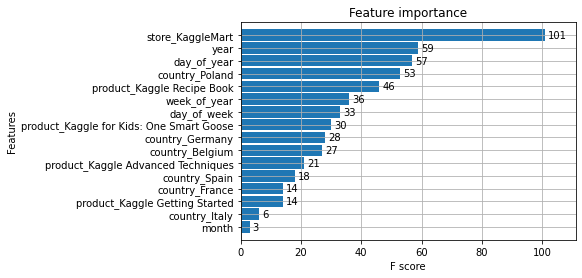

In [106]:
_ = plot_importance(reg, height=0.9)

Forcasting


In [ ]:
final_test.head()

In [ ]:
X.info()

In [ ]:
final_test.info()

In [107]:
Xhat = final_test.drop(["num_sold"], axis=1)

In [108]:
yhat_test = reg.predict(Xhat)

In [109]:
submission = pd.DataFrame([test_data['row_id'], yhat_test]).T

In [110]:
submission = submission.rename({'Unnamed 0': 'num_sold'}, axis='columns')

In [111]:
submission = submission.astype('int64')

In [112]:
submission

,row_id,num_sold
0,70128,415
1,70129,371
2,70130,318
3,70131,456
4,70132,154
...,...,...
17515,87643,469
17516,87644,158
17517,87645,150
17518,87646,130


In [113]:
submission.to_csv('kaggle_submission.csv', index=False)
!kaggle competitions submit -c tabular-playground-series-sep-2022 -m "snd xgb model 100 est" -f "kaggle_submission.csv"

100% 169k/169k [00:04<00:00, 42.5kB/s]
Successfully submitted to Tabular Playground Series - Sep 2022